In [1]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SciPy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow
import statistics as stats
from collections import defaultdict
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model                                                         

In [4]:
(x_train, y_train), (x_test, y_test)=tensorflow.keras.datasets.fashion_mnist.load_data()

In [5]:
x_train = tensorflow.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tensorflow.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tensorflow.expand_dims(x_train, axis=3, name=None)
x_test = tensorflow.expand_dims(x_test, axis=3, name=None)
x_train = tensorflow.repeat(x_train, 3, axis=3)
x_test = tensorflow.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

y_train = tensorflow.one_hot(y_train.astype(np.int32), depth=100)
y_test = tensorflow.one_hot(y_test.astype(np.int32), depth=100)

In [6]:
model_name = densenet
input_t =(32,32, 3)
model = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune1 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune4 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

In [7]:
# get the layer index
def getLayerIndex(model_i, layer_name):
    for pos, layer_g in enumerate(model_i.layers):
        if layer_g.name == layer_name:
            return pos


In [8]:
# get the convolved layers into an array for looping
convolved_layers = []

for layer in model.layers:

    t = np.array(layer.get_weights()).ndim
    array = np.array(layer.get_weights())
    if (model_name != resnet50) or (model_name != vgg16):
        if (len(array) > 0) and (t > 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))
    if (model_name == resnet50) or (model_name == vgg16):
        if len(array) > 0 and (t != 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))

# get the total number of weights in the array
total_layer_weights = 0
sum_positives = 0
sum_negatives = 0

# create a dictionary with layer index and positive values identified
layer_positives_dict = defaultdict(list)

# create a dictionary for storing the layers and their +ve values probabilities
layer_probs_dict = defaultdict(list)

In [9]:
# list the convolved layers
for c_layer in range(len(convolved_layers)):
    # create array for array matrices,feature values and convolved values for each layer
    layer_array_matrices = []
    layer_feature_sums = []
    layer_convolved_values_sum = []

    # get the arrays matrices(batches) pixel
    for i in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0])):
        # get the values for each feature
        ######print("channels(image):"+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])))
        for x in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])):
            # return all the values in the convolutional feature
            total_array = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x])
            # return all the negative values in the convolutional feature
            x2 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) < 0
            for c in range(len(x2)):
                ###print("all the trues in depth: " + str(c + 1) + " are for feature: " + str(x + 1))
                sum_negatives += sum(x2[c])
                # print(sum(x2[c]))
            # return all the values
            for y in range(len(total_array)):
                total_layer_weights += len(total_array[y])

            x1 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) > 0
            # get the values for each channel
            for a in range(len(x1)):
                value_pix = sum(x1[a])
                # get the positive values
                sum_positives += value_pix

                ######print(value_pix)
    list_sums = []
    list_sums.append((str(convolved_layers[c_layer]), sum_positives))
    layer_positives_dict.update(list_sums)

    # print the probabilities for each layer
    layer_pos_prob = sum_positives / total_layer_weights

    # create +ves values array
    positives_array = []
    for key, val in layer_positives_dict.items():
        # print(key, "corresponds to:",val," positive values")
        positives_array.append(val)
       
    list_layer_probs = []
    list_layer_probs.append((str(convolved_layers[c_layer]), layer_pos_prob))
    layer_probs_dict.update(list_layer_probs)

In [10]:
median_layer = stats.median(convolved_layers)

# create dictionary for storing selected median layers
second_layer_probs_dict = defaultdict(list)
# store the new list of layers to be matched with the mean probability
second_half_layers = []

# store all probabilities for the selected upper half layers
second_half_probs = []
# loop through the layers and print those layers above the median
for lyr, val in layer_probs_dict.items():
    # print(lyr, "Layer prob:", val)
    if int(lyr) > median_layer:
        # store the probabilities of the upper half selected convolved layers
        #print(lyr, "Layer prob:", val)
        # update the sum of selected layers probabilities
        second_half_probs.append(val)
        second_half_layers.append((lyr, val))
        second_layer_probs_dict.update(second_half_layers)

# get the mean of the layers
selected_layers_mean = stats.mean(second_half_probs)
final_selected_layers = []
# now get the final layers list whose value exceed the mean
for s_lyr, v in second_layer_probs_dict.items():
    # get the probabilities that are lower than the mean probability
    if v < selected_layers_mean:
        # store the probabilities of the upper half selected convolved layers
        final_selected_layers.append(s_lyr)

In [11]:

# for positive cosines similarities
pcs_h_layers =[332,223,153,406,93,195,58,188,2] #high cosine,,
pcs_l_layers =[514,528,521,493,535,570,577] #lower cosine
for sb_layer in model.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model, sb_layer.name)
    #for b in final_selected_layers:
    for b in pcs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for negative cosine similarities
# for model 2
# for positive cosines similarities
ncs_h_layers =[570,210,335,363,528,521,2]
ncs_l_layers =[265,55,458,139,8,51] #lower cosine
for sbs_layer in model2.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model2, sbs_layer.name)
    #for b in final_selected_layers:
    for b in ncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for positive negative cosine similarities
# for model 3
pncs_h_layers =[118,584,535,528,83,55] #high cosine,,
pncs_l_layers =[2,363,265,272,349] #lower cosine
for sbs_layer in model3.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model3, sbs_layer.name)
    #for b in final_selected_layers:
    for b in pncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)


#finetune by removeing the last layer
for lst_layer in model_tune1.layers[:-2]:
    lst_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 2nd last layer
for scnd_st_layer in model_tune2.layers[:-3]:
    scnd_st_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 3rd last layer
for thrd_layer in model_tune3.layers[:-4]:
    thrd_layer.trainable = False
    

    
####end of the last layer
#for feature extraction
for ftr_layer in model_tune4.layers:
    ftr_layer.trainable = False

# try the transfer learning model
to_res = (224, 224)


conv1/conv True
conv3_block1_2_conv True
conv3_block6_2_conv True
conv4_block2_2_conv True
conv4_block7_2_conv True
conv4_block8_2_conv True
conv4_block12_2_conv True
conv4_block28_1_conv True
conv5_block6_1_conv True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True
relu True


In [12]:

t_model = Sequential()
t_model.add(model)
t_model.add(Flatten())
t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(64, activation='relu'))
t_model.add(layers.Dropout(0.5))
t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model2 = Sequential()
t_model2.add(model2)
t_model2.add(Flatten())
t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(64, activation='relu'))
t_model2.add(layers.Dropout(0.5))
t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model3 = Sequential()
t_model3.add(model3)
t_model3.add(Flatten())
t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(64, activation='relu'))
t_model3.add(layers.Dropout(0.5))
t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model4 = Sequential()
t_model4.add(model_tune1)
t_model4.add(Flatten())
t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(64, activation='relu'))
t_model4.add(layers.Dropout(0.5))
t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(100, activation='softmax'))

#for model 2
t_model5 = Sequential()
t_model5.add(model_tune2)
t_model5.add(Flatten())
t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(64, activation='relu'))
t_model5.add(layers.Dropout(0.5))
t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(100, activation='softmax'))

#for model 2
t_model6 = Sequential()
t_model6.add(model_tune3)
t_model6.add(Flatten())
t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(64, activation='relu'))
t_model6.add(layers.Dropout(0.5))
t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model7 = Sequential()
t_model7.add(model_tune3)
t_model7.add(Flatten())
t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(64, activation='relu'))
t_model7.add(layers.Dropout(0.5))
t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(100, activation='softmax'))

In [13]:
#positive cosine similarity
t_model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history = t_model.fit(x_train, y_train, batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 119s 110ms/step - loss: 4.6137 - accuracy: 0.0422 - val_loss: 3.4768 - val_accuracy: 0.4711
Epoch 2/20
907/907 [==============================] - 95s 105ms/step - loss: 3.4491 - accuracy: 0.3390 - val_loss: 2.7065 - val_accuracy: 0.6860
Epoch 3/20
907/907 [==============================] - 97s 107ms/step - loss: 2.8664 - accuracy: 0.5521 - val_loss: 2.3399 - val_accuracy: 0.7506
Epoch 4/20
907/907 [==============================] - 96s 105ms/step - loss: 2.5638 - accuracy: 0.6500 - val_loss: 2.1052 - val_accuracy: 0.7893
Epoch 5/20
907/907 [==============================] - 96s 105ms/step - loss: 2.3598 - accuracy: 0.7022 - val_loss: 1.9353 - val_accuracy: 0.8107
Epoch 6/20
907/907 [==============================] - 95s 105ms/step - loss: 2.1925 - accuracy: 0.7373 - val_loss: 1.7885 - val_accuracy: 0.8252
Epoch 7/20
907/907 [==============================] - 96s 105ms/step - loss: 2.0642 - accuracy: 0.7611 - val_loss: 1.6597 - val_a

In [14]:
#negative cosine similarity look
#for model2
t_model2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history2 = t_model2.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 115s 109ms/step - loss: 4.6353 - accuracy: 0.0368 - val_loss: 3.4822 - val_accuracy: 0.4680
Epoch 2/20
907/907 [==============================] - 97s 107ms/step - loss: 3.4655 - accuracy: 0.3207 - val_loss: 2.7119 - val_accuracy: 0.7063
Epoch 3/20
907/907 [==============================] - 96s 106ms/step - loss: 2.8846 - accuracy: 0.5487 - val_loss: 2.3752 - val_accuracy: 0.7684
Epoch 4/20
907/907 [==============================] - 96s 106ms/step - loss: 2.5821 - accuracy: 0.6483 - val_loss: 2.1476 - val_accuracy: 0.8007
Epoch 5/20
907/907 [==============================] - 95s 105ms/step - loss: 2.3686 - accuracy: 0.7060 - val_loss: 1.9789 - val_accuracy: 0.8177
Epoch 6/20
907/907 [==============================] - 95s 105ms/step - loss: 2.2106 - accuracy: 0.7390 - val_loss: 1.8039 - val_accuracy: 0.8321
Epoch 7/20
907/907 [==============================] - 96s 106ms/step - loss: 2.0769 - accuracy: 0.7660 - val_loss: 1.6833 - val_a

In [15]:
#for model3
t_model3.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history3 = t_model3.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 116s 110ms/step - loss: 4.6008 - accuracy: 0.0425 - val_loss: 3.3562 - val_accuracy: 0.4762
Epoch 2/20
907/907 [==============================] - 97s 107ms/step - loss: 3.4054 - accuracy: 0.3337 - val_loss: 2.6825 - val_accuracy: 0.7075
Epoch 3/20
907/907 [==============================] - 96s 106ms/step - loss: 2.8475 - accuracy: 0.5482 - val_loss: 2.3157 - val_accuracy: 0.7675
Epoch 4/20
907/907 [==============================] - 98s 108ms/step - loss: 2.5445 - accuracy: 0.6501 - val_loss: 2.0776 - val_accuracy: 0.7947
Epoch 5/20
907/907 [==============================] - 97s 107ms/step - loss: 2.3354 - accuracy: 0.7081 - val_loss: 1.8924 - val_accuracy: 0.8104
Epoch 6/20
907/907 [==============================] - 97s 107ms/step - loss: 2.1589 - accuracy: 0.7513 - val_loss: 1.7438 - val_accuracy: 0.8223
Epoch 7/20
907/907 [==============================] - 98s 108ms/step - loss: 2.0263 - accuracy: 0.7719 - val_loss: 1.6208 - val_a

In [16]:
#for model3
t_model4.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history4= t_model4.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)



Epoch 1/20
907/907 [==============================] - 46s 40ms/step - loss: 4.8296 - accuracy: 0.0221 - val_loss: 4.1259 - val_accuracy: 0.1957
Epoch 2/20
907/907 [==============================] - 33s 37ms/step - loss: 4.2378 - accuracy: 0.1074 - val_loss: 3.7008 - val_accuracy: 0.3549
Epoch 3/20
907/907 [==============================] - 33s 36ms/step - loss: 3.8697 - accuracy: 0.2000 - val_loss: 3.4046 - val_accuracy: 0.4470
Epoch 4/20
907/907 [==============================] - 32s 36ms/step - loss: 3.6082 - accuracy: 0.2780 - val_loss: 3.1731 - val_accuracy: 0.5119
Epoch 5/20
907/907 [==============================] - 32s 36ms/step - loss: 3.3900 - accuracy: 0.3439 - val_loss: 2.9994 - val_accuracy: 0.5554
Epoch 6/20
907/907 [==============================] - 32s 36ms/step - loss: 3.2262 - accuracy: 0.3923 - val_loss: 2.8444 - val_accuracy: 0.5896
Epoch 7/20
907/907 [==============================] - 33s 36ms/step - loss: 3.0800 - accuracy: 0.4336 - val_loss: 2.7150 - val_accuracy:

In [17]:
#for model3
t_model5.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history5 = t_model5.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 43s 38ms/step - loss: 4.8701 - accuracy: 0.0117 - val_loss: 4.2408 - val_accuracy: 0.1115
Epoch 2/20
907/907 [==============================] - 32s 35ms/step - loss: 4.3809 - accuracy: 0.0552 - val_loss: 3.8318 - val_accuracy: 0.2782
Epoch 3/20
907/907 [==============================] - 32s 35ms/step - loss: 4.0133 - accuracy: 0.1319 - val_loss: 3.5413 - val_accuracy: 0.4078
Epoch 4/20
907/907 [==============================] - 32s 35ms/step - loss: 3.7522 - accuracy: 0.2114 - val_loss: 3.3317 - val_accuracy: 0.4822
Epoch 5/20
907/907 [==============================] - 31s 35ms/step - loss: 3.5529 - accuracy: 0.2819 - val_loss: 3.1536 - val_accuracy: 0.5240
Epoch 6/20
907/907 [==============================] - 31s 35ms/step - loss: 3.3845 - accuracy: 0.3409 - val_loss: 2.9996 - val_accuracy: 0.5567
Epoch 7/20
907/907 [==============================] - 32s 35ms/step - loss: 3.2251 - accuracy: 0.3949 - val_loss: 2.8654 - val_accuracy:

In [18]:
#for model3
t_model6.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history6 = t_model6.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 46s 40ms/step - loss: 4.8917 - accuracy: 0.0172 - val_loss: 4.0942 - val_accuracy: 0.1885
Epoch 2/20
907/907 [==============================] - 33s 36ms/step - loss: 4.1894 - accuracy: 0.1014 - val_loss: 3.5906 - val_accuracy: 0.3723
Epoch 3/20
907/907 [==============================] - 33s 37ms/step - loss: 3.7622 - accuracy: 0.2139 - val_loss: 3.2735 - val_accuracy: 0.4837
Epoch 4/20
907/907 [==============================] - 33s 36ms/step - loss: 3.4716 - accuracy: 0.3023 - val_loss: 3.0423 - val_accuracy: 0.5518
Epoch 5/20
907/907 [==============================] - 33s 37ms/step - loss: 3.2609 - accuracy: 0.3713 - val_loss: 2.8559 - val_accuracy: 0.6036
Epoch 6/20
907/907 [==============================] - 34s 37ms/step - loss: 3.0914 - accuracy: 0.4282 - val_loss: 2.7030 - val_accuracy: 0.6385
Epoch 7/20
907/907 [==============================] - 33s 36ms/step - loss: 2.8173 - accuracy: 0.5149 - val_loss: 2.4403 - val_accuracy:

In [19]:
#for model3
t_model7.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history7 = t_model7.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 49s 43ms/step - loss: 4.7887 - accuracy: 0.0190 - val_loss: 4.1091 - val_accuracy: 0.1614
Epoch 2/20
907/907 [==============================] - 36s 40ms/step - loss: 4.2323 - accuracy: 0.0843 - val_loss: 3.6903 - val_accuracy: 0.3470
Epoch 3/20
907/907 [==============================] - 35s 39ms/step - loss: 3.8693 - accuracy: 0.1736 - val_loss: 3.4023 - val_accuracy: 0.4667
Epoch 4/20
907/907 [==============================] - 35s 39ms/step - loss: 3.6036 - accuracy: 0.2588 - val_loss: 3.1794 - val_accuracy: 0.5391
Epoch 5/20
907/907 [==============================] - 36s 40ms/step - loss: 3.3990 - accuracy: 0.3280 - val_loss: 2.9873 - val_accuracy: 0.5878
Epoch 6/20
907/907 [==============================] - 36s 40ms/step - loss: 3.2194 - accuracy: 0.3890 - val_loss: 2.8330 - val_accuracy: 0.6223
Epoch 7/20
907/907 [==============================] - 36s 40ms/step - loss: 3.0663 - accuracy: 0.4391 - val_loss: 2.6903 - val_accuracy:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


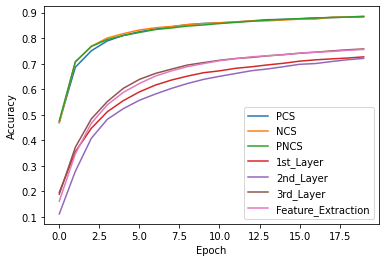

In [21]:
fig1 = plt.figure()
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_accuracy'])
#plt.plot(history6.history['val_loss'])
plt.plot(history7.history['val_accuracy'])
#plt.plot(history6.history['val_loss'])
#plt.title('Model Training Loss Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc='lower right')

fig1.savefig('all_similarity_fashion_mnist_densenet.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


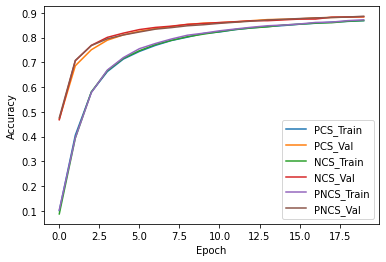

In [23]:
fig2 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='lower right')

fig2.savefig('3plots_fashion_mnist_densenet.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


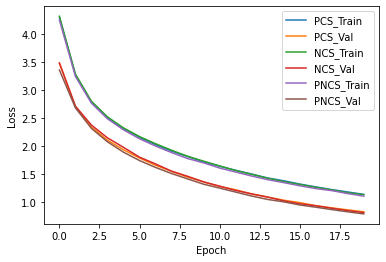

In [25]:
fig3 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='upper right')

fig3.savefig('3plots_Loss_fashion_mnist_densenet.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()